# Covid Patient Health Assessing Device Using Sliding Window

This notebook mimics [the one from @Manivannan](https://www.hackster.io/manivannan/covid-patient-health-assessing-device-using-edge-impulse-3f1151), where he develops "A pocket-sized medical device based on TinyML application using Edge Impulse to predicts the Covid patient's health conditions."

Here we're using the exact same dataset, but with a very different approach: instead of using Neural Networks (a 32 + 16 + 8 + 4 fully connected network), we'll use a simple **sliding window with some basic statistics** (min / max / mean / std...).

This sliding window approach will come useful in many other situations where you'll be working with time-series data (IMU gesture classification, vibration pattern classification, ...).

The whole system resolves around a Python class that you fit on your data and that transpiles to plain C++, ready to be embedded inside your project **with no external dependencies!**.

## 1. Generate data

This is an *exact* copy of the original post: we're going to generate synthetic data that mimics the expected behavior of Covid patatients.

From the plots below you will notice that the different classes are very different from each other and well separable: using a Neural Network for this task is, in my opinion, **overkill** at best!

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
plt.rcParams["figure.figsize"] = (10, 5)

In [39]:
"""
Generate syntethic data
"""
# Number of sample datapoints
SAMPLES = 1800

# Generate a uniformly distributed set of random numbers in the range from
minutes = np.random.uniform(low=0, high=1500, size=SAMPLES).astype(np.uint32)

# Stable Condition
# SpO2 Range = 96 to 100
#Respiratory Rate = 12 to 20
#Pulse = 51 to 90
#Body Temperature = 96 to 100

StableSpO2=np.random.uniform(low=96, high=100, size=SAMPLES).astype(np.uint8)
StableRR=np.random.uniform(low=12, high=20, size=SAMPLES).astype(np.uint8)
StablePulse=np.random.uniform(low=51, high=90, size=SAMPLES).astype(np.uint8)
StableTemp=np.random.uniform(low=96, high=100, size=SAMPLES).astype(np.float32)



# Mild Condition
# SpO2 Range = 93 to 95
#Respiratory Rate = 21 to 24
#Pulse = 41 to 50
#Body Temperature = 100 to 102

MildSpO2=np.random.uniform(low=93, high=95, size=SAMPLES).astype(np.uint8)
MildRR=np.random.uniform(low=21, high=24, size=SAMPLES).astype(np.uint8)
MildPulse=np.random.uniform(low=41, high=50, size=SAMPLES).astype(np.uint8)
MildTemp=np.random.uniform(low=100, high=102, size=SAMPLES).astype(np.float32)


# Moderate Condition
# SpO2 Range = 90 to 92
#Respiratory Rate = 25 to 30
#Pulse = 41 to 50
#Body Temperature = 102 to 106


ModerateSpO2=np.random.uniform(low=90, high=92, size=SAMPLES).astype(np.uint8)
ModerateRR=np.random.uniform(low=25, high=30, size=SAMPLES).astype(np.uint8)
ModeratePulse=np.random.uniform(low=41, high=50, size=SAMPLES).astype(np.uint8)
ModerateTemp=np.random.uniform(low=102, high=106, size=SAMPLES).astype(np.float32)


# Critical Condition
# SpO2 Range = 80 to 90
#Respiratory Rate = 30 to 40
#Pulse = 30 to 40
#Body Temperature = 102 to 106


CriticalSpO2=np.random.uniform(low=80, high=90, size=SAMPLES).astype(np.uint8)
CriticalRR=np.random.uniform(low=30, high=40, size=SAMPLES).astype(np.uint8)
CriticalPulse=np.random.uniform(low=30, high=40, size=SAMPLES).astype(np.uint8)
CriticalTemp=np.random.uniform(low=102, high=106, size=SAMPLES).astype(np.float32)

In [40]:
"""
Format as pd.DataFrame
"""

stable = pd.DataFrame(list(zip(StableSpO2, StableRR, StablePulse, StableTemp)), columns=['spo2', 'rr', 'pulse', 'temp'])
mild = pd.DataFrame(list(zip(MildSpO2, MildRR, MildPulse, MildTemp)), columns=['spo2', 'rr', 'pulse', 'temp'])
moderate = pd.DataFrame(list(zip(ModerateSpO2, ModerateRR, ModeratePulse, ModerateTemp)), columns=['spo2', 'rr', 'pulse', 'temp'])
critical = pd.DataFrame(list(zip(CriticalSpO2, CriticalRR, CriticalPulse, CriticalTemp)), columns=['spo2', 'rr', 'pulse', 'temp'])

<AxesSubplot:title={'center':'Stable'}>

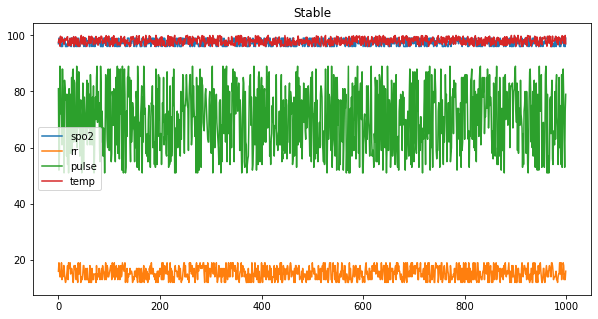

In [41]:
stable.plot(title='Stable')

<AxesSubplot:title={'center':'Mild'}>

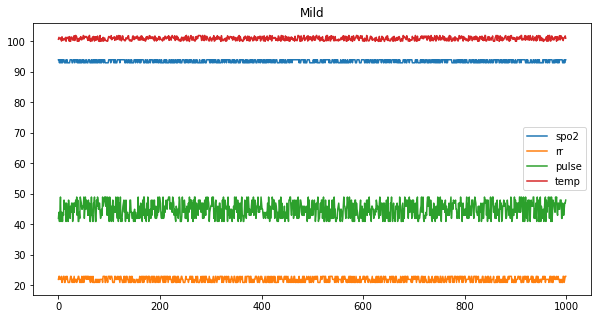

In [42]:
mild.plot(title='Mild')

<AxesSubplot:title={'center':'Moderate'}>

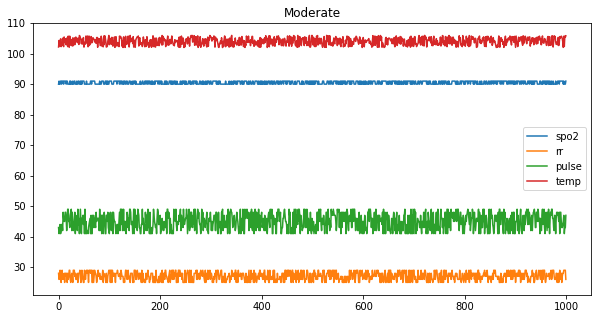

In [43]:
moderate.plot(title='Moderate')

<AxesSubplot:title={'center':'Critical'}>

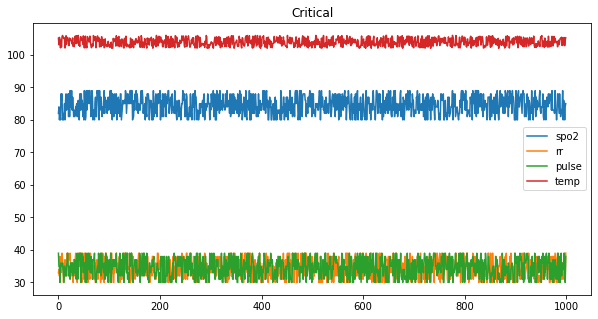

In [44]:
critical.plot(title='Critical')

In [45]:
"""
Format pd.DataFrames as numpy matrices for pre-processing/training
"""
X = np.vstack((stable.to_numpy(), mild.to_numpy(), moderate.to_numpy(), critical.to_numpy()))
y = np.concatenate([i * np.ones(SAMPLES) for i in range(4)])

## 2. Apply sliding window

A sliding window (also called rolling window) is a window that selects only a chunk of data at each step. It moves forward by a given *shift*, selecting each time different elements.

It is often the case that these windows overlaps, thus covering a given event from different time perspectives. In Machine Learning tasks this greatly helps creating features that are (to some degree) time invariant, or better, that describe the same event with different features, making the classifier more robust.

The `emebedded_window` package has a single class, called `Window`, that implements this mechanism.

```bash
# install with
pip install embedded_window
```

Visit [the package repo on Github](https://github.com/eloquentarduino/embedded_window) to look at the code and remember to star!

In [57]:
"""
Apply sliding window
"""
from embedded_window import Window

window = Window(length=20, shift=5)

# X_w holds the input arranged in windows. Shape is (-1, length, X.shape[1])
# features holds the extracted features for each window (min/max/mean/std...)
# y_w holds the most frequent label inside each window 
X_w, features, y_w = window.fit_transform(X, y)

print('X_w.shape     ', X_w.shape)
print('features.shape', features.shape)
print('y_w.shape     ', y_w.shape)

X_w.shape      (797, 20, 4)
features.shape (797, 32)
y_w.shape      (797,)


In [47]:
"""
Print a few samples of each distribution
"""
print('X[:20]\n', X[:20], '\n================')
print('X_w[0] (should match X[:20])\n', X_w[0], '\n================')
print('features[0]\n', features[0], '\n================')

X[:20]
 [[97.         16.         81.         97.43538666]
 [99.         19.         52.         98.61500549]
 [99.         16.         58.         98.26636505]
 [99.         14.         89.         96.13642883]
 [97.         14.         88.         99.6827774 ]
 [96.         16.         72.         97.52001953]
 [96.         19.         76.         97.51760864]
 [97.         13.         61.         99.38542175]
 [96.         16.         88.         97.9371109 ]
 [98.         14.         77.         97.80427551]
 [98.         18.         77.         98.55942535]
 [97.         18.         51.         96.84708405]
 [99.         15.         84.         98.11320496]
 [98.         13.         81.         98.67427063]
 [96.         12.         77.         98.15510559]
 [96.         13.         79.         98.83504486]
 [96.         14.         57.         98.39414978]
 [97.         16.         79.         99.36562347]
 [96.         18.         54.         99.51668549]
 [98.         13.      

## 3. Fit classifier

Once we have our features, we can fit any classifier on them. For this task even a Decision Tree will perform good.

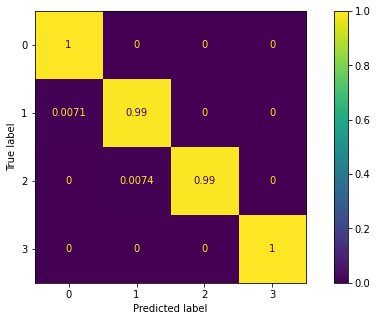

In [56]:
"""
Fit classifier on window features
"""
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(features, y_w, test_size=0.7)
clf = DecisionTreeClassifier(max_depth=20).fit(X_train, y_train)

plot_confusion_matrix(clf, X_test, y_test, normalize='true')

## 4. Port to C++

Now that we know our features are good at classifying our data, it's time to export the sliding window to plain C++. Guess what? It's a **one liner!**.

In [49]:
"""
Port to plain C++
"""
print(window.port())


        #ifndef __WINDOW__4888498416
        #define __WINDOW__4888498416
        
        class Window {
            public:
                const uint16_t features_count = 32;
                float features[32];
                
                /**
                 * Extract features
                 */
                 bool transform(float *x, float *dest = NULL) {
                    // append source to queue
                    memcpy(queue + head, x, sizeof(float) * 4);
                    head += 4;

                    if (head != 80) {
                        return false;
                    }

                    // extract features for each axis
                    uint16_t feature_idx = 0;
                    
                    for (uint16_t j = 0; j < 4; j++) {
                        float m = x[j];
                        float M = m;
                        float abs_m = abs(m);
                        float abs_M = abs_m;
                        float mean = m;
   

## 5. Use in Arduino C++

Here is a short example on how to use the exported code in an Arduino project. The class is totally self-contained and doesn't need any further configuration.

It expones the following API:

 - `bool transform(float *x, float *dest = NULL)`: adds the `x` sample to the window. When the window is full, it returns `true` and you can safely access the generated features. It will copy the features to `dest`, if provided.
 - `float *features`: is an array containing the computed features that you can use for classification
 - `const uint16_t features_count`: the number of generated features (useful to iterate on the array, for example)
 
Following a minimal sketch that shows how to actually use the class.


```cpp
#include "Window.h"


Window window;
float X[30][4] = {...};


void setup() {
  Serial.begin(115200);
  delay(2000);
}

void loop() {
  for (int i = 0; i < 30; i++) {
    if (window.transform(X[i])) {
      print_array(window.features, window.features_count);
    }
  }

  delay(60000);
}

/**
 * Print array of given number of elements
 */
void print_array(float *array, int size) {
  for (int i = 0; i < size - 1; i++) {
    Serial.print(array[i]);
    Serial.print(", ");
  }

  Serial.println(array[size - 1]);
}

```

## 6. Go invent

This sliding window may be used as a foundation for many other kind of tasks. The extracted features are really simple at the moment, but will cover simple problems like the one described here (I already implemented many other features, but will integrate them later in a different class).

The hope is: before blindly using Neural Networks, think twice if there's a lighter, easier, faster way to deal with the problem at hand!